# Determining xy-coordinates of pupil in image

The purpose of this study is to develop a network that can pinpoint the xy-coordinates (pixel value) of the pupil centre of an eye. The model is to be deployed using AWS and output xy-values given the image that is passed.

> **_STRETCH_**: As a stretch activity, let's also try to output the image  overlaid with a red dot that marks the xy-coorindate position of the pupil.

In [1]:
from modules import config, utils, model
import cv2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')
%matplotlib inline

### `OpenCV` Functionality

- `cv.imread()` reads an image as an array

In [2]:
# print all flags for colour conversions
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print(flags)

['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_BGGR2BGR', 'COLOR_BAYER_BGGR2BGRA', 'COLOR_BAYER_BGGR2BGR_EA', 'COLOR_BAYER_BGGR2BGR_VNG', 'COLOR_BAYER_BGGR2GRAY', 'COLOR_BAYER_BGGR2RGB', 'COLOR_BAYER_BGGR2RGBA', 'COLOR_BAYER_BGGR2RGB_EA', 'COLOR_BAYER_BGGR2RGB_VNG', 'COLOR_BAYER_GB2BGR', 'COLOR_BAYER_GB2BGRA', 'COLOR_BAYER_GB2BGR_EA', 'COLOR_BAYER_GB2BGR_VNG', 'COLOR_BAYER_GB2GRAY', 'COLOR_BAYER_GB2RGB', 'COLOR_BAYER_GB2RGBA', 'COLOR_BAYER_GB2RGB_EA', 'COLOR_BAYER_GB2RGB_VNG', 'COLOR_BAYER_GBRG2BGR', 'COLOR_BAYER_GBRG2BGRA', 'COLOR_BAYER_GBRG2BGR_EA', 'COLOR_BAYER_GBRG2BGR_VNG', 'COLOR_BAYER_GBRG2GRAY', 'COLOR_BAYER_GBRG2RGB', 'COLOR_BAYER_GBRG2RGBA', 'COLOR_BAYER_GBRG2RGB_EA', 'COLOR_BAYER_GBRG2RGB_VNG', 'COLOR_BAYER_GR2BGR', 'COLOR_BAYER_GR2BGRA', 'COLOR_BAYER_GR2BGR_EA', 'COLOR_BAYER_GR2BGR_VNG', 'COLOR_

- `cv.resize()` manually scales the image

In [3]:
# print all flags for resizing methods
flags = [i for i in dir(cv2) if i.startswith('INTER_')]
print(flags)

['INTER_AREA', 'INTER_BITS', 'INTER_BITS2', 'INTER_CUBIC', 'INTER_LANCZOS4', 'INTER_LINEAR', 'INTER_LINEAR_EXACT', 'INTER_MAX', 'INTER_NEAREST', 'INTER_NEAREST_EXACT', 'INTER_TAB_SIZE', 'INTER_TAB_SIZE2']


#### Transformations

- `cv.warpAffine(img, M, (cols, rows))`
    - `rows`, `cols` is `image.shape` or _width_, _height_
    - `M` is a transformation matrix (e.g., `np.float32([ [1,0,100], [0,1,50] ])`)
    - `M` as `cv.getRotationMatrix2D( ( ( cols-1)/2.0, (rows-1)/2.0 ), 90, 1)` rotates the image by 90 degrees around center
    - `M` as `cv.getAffineTransform(pts1, pts2)` where `pts` are arrays of xy-points, before and after the transform
    = `M` as `cv.getPrespectiveTransform(pts1, pts2)` where `pts` are arrays of xy-points, before and after the transform

### Saving Images

Open palette image and remove pointless alpha channel \
`im = Image.open('image.png').convert('P')`

Extract palette and save as CSV \
`np.array(im.getpalette()).tofile('palette.csv',sep=',')`

Save palette indices as single channel PGM image that OpenCV can read \
`na = np.array(im)`
`im = Image.fromarray(na).save('indices.pgm')`

First load indices \
`im = Image.open('indices.pgm')`

Now load palette \
`palette = np.fromfile('palette.csv',sep=',').astype(np.uint8)`

Put palette back into image \
`im.putpalette(palette)`

Save \
`im.save('result.png')`

## Import dataset

The dataset we will be using is the [gaze dataset](https://www.kaggle.com/datasets/4quant/eye-gaze) on Kaggle.

We have defined our target as `keypoints` and the data as `images`. The `images` dataset will be converted to a dataframe and saved, while the `keypoints` can be saved directly since it is imported as a dataframe.

In [4]:
## ALREADY RUN ##

# series of image locations (urls)
image_locs = utils.get_image_locs()[::12]

# convert image to dataframe and save (45min)
df_images = utils.get_images(save=True, return_df=False)

# target dataframe and output
df_keypoints = utils.get_keypoints(with_image_locs=True, save=True)[::12]

In [17]:
# load csv files (13s)
img_arrays = pd.read_csv( os.path.sep.join([out, 'person1_img.csv']) )
keypoints = pd.read_csv( os.path.sep.join([out, 'person1_kpts.csv']) )

In [21]:
keypoints.shape

(5999, 4)

## Testing Grounds for Plotting and Functions

In [19]:
# take sample image data and define output parameters
sample_imgs = images[:300:30]
sample_kpts = keypoints[['x', 'y']].iloc[:300:30, :]

NameError: name 'images' is not defined

In [20]:
# convert sample image data to arrays and save to file
sample_img_arrays = utils.convert_image(
    imgs=sample_imgs,
    color=color,
    save=False,
    pathname=os.path.sep.join([out, f'sample_array.csv']),
    to_df=False)

# convert sample image data to dataframe
sample_img_df = utils.convert_image(
    imgs=sample_imgs,
    color=color,
    save=False,
    pathname=None,
    to_df=True)

NameError: name 'sample_imgs' is not defined

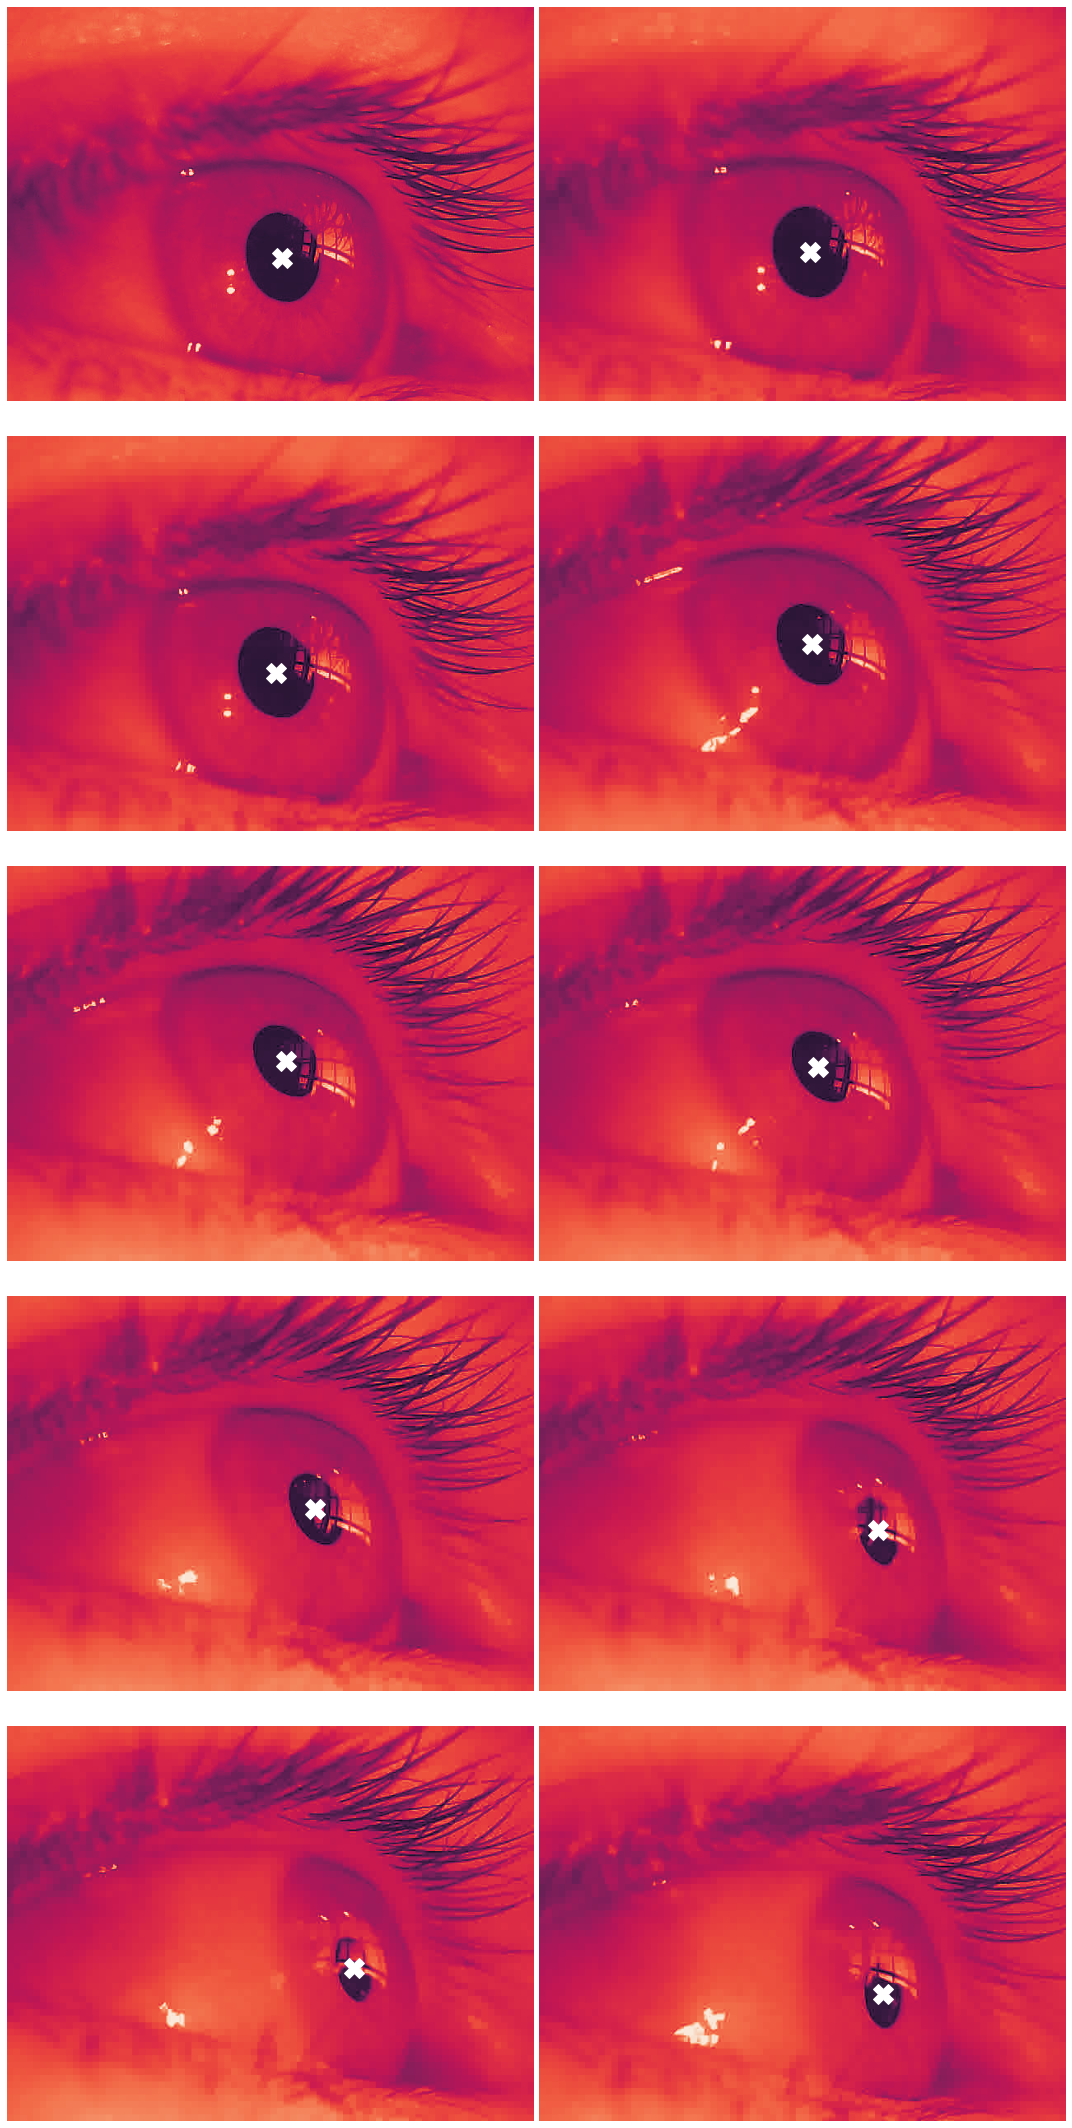

In [ ]:
# plot converted sample image data along with keypoints data
image_arrays = utils.plot_image_keypoints(
    sample_img_arrays,
    keypoints=sample_kpts,
    markercolor='white',
    markersize=20,
    marker='X')

## Train/Test Data Split

Split 80/20 train/test respectively.

In [22]:
from sklearn.model_selection import train_test_split

# X data images are only pathnames and must be converted into arrays first
Xtrain, Xtest, ytrain, ytetst = train_test_split(img_arrays, keypoints[['x', 'y']], test_size=config.SPLIT)
# converted images to array
Xtrain_array = utils.image_to_array(Xtrain)
Xtest_array = utils.image_to_array(Xtest)

ValueError: Found input variables with inconsistent numbers of samples: [480000, 5999]

## Feature Engineering

The goal is to downsample while still retain enough fidelity to ensure accurate predictions for the keypoints.

In [ ]:
Xtrain_array.tofile('train.csv', sep=',')

In [ ]:
# X = np.array([np.array(Image.open(img), 'float') for img in images])

In [ ]:
# X.shape